In [1]:
#Import libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random

In [2]:
#Read README, then put the path to the folder with images
PATH = 'data\\jpg\\'

In [3]:
#Check if GPU is available (not necessary)
tf.config.list_physical_devices('GPU') 

[]

In [4]:
#List of images
files = os.listdir(PATH)

In [60]:
#Get random image from dataset, also data augmentation
height, width = 256, 256
def GetImg(height, width):
    GetRndImg = files[(random.randint(1, len(files) - 1))]
    Img = cv2.imread(f"{PATH}{GetRndImg}")
    #Img = cv2.imread(f"{PATH}MyOwnImage.jpg") #Use this line to use your own image
    Img = tf.image.resize(Img, [height, width])
    if tf.random.uniform(()) > 0.5:
        Img = tf.image.flip_left_right(Img)
    if tf.random.uniform(()) > 0.5:
        Img = tf.image.flip_up_down(Img)
    Img = Img / 127.5 - 1
    return tf.expand_dims(Img, axis=0)

In [74]:
#X_train 
def ProccesImg(Img):
    global height, width
    resizeTo = random.randint(24, 64)
    Img = tf.image.resize(Img, [resizeTo, resizeTo])
    Img = tf.image.resize(Img, [height, width])
    return Img

In [9]:
from tensorflow.keras.layers import *

In [10]:
#Downsample layers
def downsample(filters, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(Conv2D(filters, kernel_size=4, strides=2, padding='same', kernel_initializer=initializer, use_bias=not apply_batchnorm))

    if apply_batchnorm:
        result.add(BatchNormalization())

    result.add(LeakyReLU())

    return result

downsample(64)

In [11]:
#Upsample layers
def upsample(filters, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(Conv2DTranspose(filters, kernel_size=4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

    result.add(BatchNormalization())

    if apply_dropout:
        result.add(Dropout(0.5))

    result.add(ReLU())

    return result

upsample(64)

In [12]:
#Create our generator
def Generator():
    initializer = tf.random_normal_initializer(0, 0.02)

    inputs = tf.keras.layers.Input(shape=[None, None, 3])

    down_stack = [
        downsample(64, apply_batchnorm=False), # (bs, 128, 128, 64)
        downsample(128),                       # (bs, 64, 64, 128)
        downsample(256),                       # (bs, 32, 32, 256)
        downsample(512),                       # (bs, 16, 16, 512)
        downsample(512),                       # (bs, 8, 8, 512)
        downsample(512),                       # (bs, 4, 4, 512)
        downsample(512),                       # (bs, 2, 2, 512)
        downsample(512),                       # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, apply_dropout=True),  # (bs, 4, 4, 1024)
        upsample(512, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512),                      # (bs, 16, 16, 1024)
        upsample(256),                      # (bs, 32, 32, 512)
        upsample(128),                      # (bs, 64, 64, 256)
        upsample(64),                       # (bs, 128, 128, 128)
    ]

    last = Conv2DTranspose(filters=3, kernel_size=4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh') # (bs, 256, 256, 3)
    #Skip the last layer of downsampling, and the first layer of upsampling
    x = inputs
    s = []
    skip = 1

    concat = Concatenate()

    for down in down_stack:
        x = down(x)
        s.append(x)
    s = reversed(s[:-skip])
    for up, sk in zip(up_stack, s):
        x = up(x)
        x = concat([x, sk])
    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

generator = Generator()

In [13]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 sequential_2 (Sequential)   (None, None, None, 64)       3136      ['input_1[0][0]']             
                                                                                                  
 sequential_3 (Sequential)   (None, None, None, 128)      131584    ['sequential_2[0][0]']        
                                                                                                  
 sequential_4 (Sequential)   (None, None, None, 256)      525312    ['sequential_3[0][0]']        
                                                                                              

In [16]:
#Create our discriminator model
def Discriminator():
    initializer = tf.random_normal_initializer(0, 0.02)

    inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')

    both = tf.keras.layers.concatenate([inp, tar])                 # (bs, 256, 256, channels*2) #Use a PatchGAN to predict if the image is real or not

    down1 = downsample(64, apply_batchnorm=False)(both)            # (bs, 128, 128, 64)
    down2 = downsample(128)(down1)                                 # (bs, 64, 64, 128)
    down3 = downsample(256)(down2)                                 # (bs, 32, 32, 256)

    last = Conv2D(filters=1, kernel_size=4, strides=1, padding='same', kernel_initializer=initializer)(down3)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

discriminator = Discriminator()

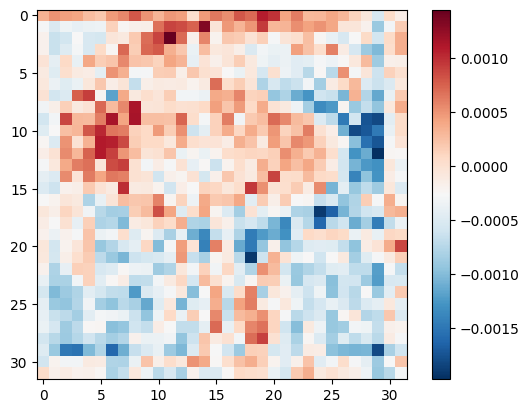

In [21]:
plt.imshow(np.array(discriminator([generator(GetImg(height, width)), generator(GetImg(height, width))])).reshape(32, 32), cmap='RdBu_r')
plt.colorbar()

In [22]:
#Use BinaryCrossentropy instead as the loss function
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [23]:
#Define our loss functions (discriminator)
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [24]:
#Define our loss functions (generator)
def generator_loss(disc_generated_output, gen_output, target):
    LAMBDA = 100
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss

In [25]:
#Define our optimizers
gen_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
dis_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [23]:
#Define our training step
#@tf.function #Use this line to use Eager Execution
def train_step():
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        real_y = GetImg(height, width)
        real_x = ProccesImg(real_y)
        gen_output = generator(real_x)
        
        disc_real_output = discriminator([real_x, real_y], training=True)
        disc_generated_output = discriminator([real_x, gen_output], training=True)

        gen_loss = generator_loss(disc_generated_output, gen_output, real_y)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_opt.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    dis_opt.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    print(gen_loss.numpy(), disc_loss.numpy())

In [24]:
from IPython.display import clear_output

In [42]:
#Use these lines to load a model
#from tensorflow import keras
#generator = keras.models.load_model('generator.weights.h5')
#discriminator = keras.models.load_model('discriminator.weights.h5')

In [118]:
epochs = 18000 #I recomend using 18000 epochs
for i in range(epochs):
    Img = GetImg(height, width) #We we'll save these images
    GenImg = np.array(generator(ProccesImg(Img))).reshape(256, 256, 3) + 1 #We we'll save these images #We also add 1 to the images because the generator output is a tahn, so we add 1 to have an image between 0 and 1
    GivImg = np.array(ProccesImg(Img)).reshape(256, 256, 3) + 1 #We we'll save these images
    print(plt.imshow(GenImg))
    print(f"Epoch: {i}/{epochs}")
    train_step()
    clear_output(wait=True)
    Img = np.array(Img).reshape(256, 256, 3) + 1
    Img = cv2.cvtColor(Img * 150, cv2.COLOR_RGB2BGR) #Transform numpy to image
    GenImg = cv2.cvtColor(GenImg * 150, cv2.COLOR_RGB2BGR) #Transform numpy to image
    GivImg = cv2.cvtColor(GivImg * 150, cv2.COLOR_RGB2BGR) #Transform numpy to image
    cv2.imwrite('GivenImage.jpg', GivImg) #Save images
    cv2.imwrite('GeneratedImage.jpg', GenImg) #Save images
    cv2.imwrite('RealImage.jpg', Img) #Save images
    try: #Save our models every epoch
        generator.save('generator.weights.h5')
        discriminator.save('discriminator.weights.h5')
        print("Saved")
    except:
        print("Error saving")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


AxesImage(shape=(256, 256, 3))
Epoch: 16723/1000000000


: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


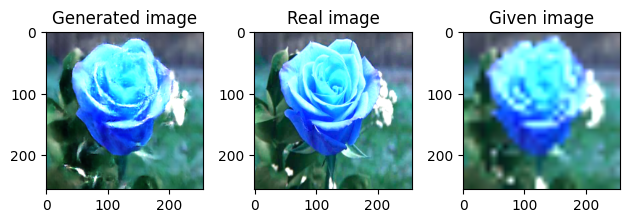

In [79]:
#Show prediction
Image = GetImg(height, width) #I'm using my own image
fig, axs = plt.subplots(1, 3)
axs[0].imshow(np.array(generator(ProccesImg(Image))).reshape(256, 256, 3) + 1)
axs[0].set_title('Generated image')
axs[1].imshow(np.array(Image).reshape(256, 256, 3) + 1)
axs[1].set_title('Real image')
axs[2].imshow(np.array(ProccesImg(Image)).reshape(256, 256, 3) + 1)
axs[2].set_title('Given image')

plt.tight_layout()
plt.show()